In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
sb.set_style('dark')

import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
#from skopt.plots import plot_histogram, plot_objective_2D
from skopt.utils import use_named_args

ModuleNotFoundError: No module named 'skopt'

In [3]:
agedata = pd.read_csv('abalone_age.csv')

agedata.rename(columns = {'Column1':'sex'}, inplace = True)
agedata.rename(columns = {'Column2':'Length'}, inplace = True)
agedata.rename(columns = {'Column3':'diameter'}, inplace = True)
agedata.rename(columns = {'Column4':'height'}, inplace = True)
agedata.rename(columns = {'Column5':'total.w'}, inplace = True)
agedata.rename(columns = {'Column6':'meat.w'}, inplace = True)
agedata.rename(columns = {'Column7':'gut.w'}, inplace = True)
agedata.rename(columns = {'Column8':'shell.w'}, inplace = True)
agedata.rename(columns = {'Column9':'rings'}, inplace = True)
agedata.columns = agedata.columns.str.upper()
agedata

,SEX,LENGTH,DIAMETER,HEIGHT,TOTAL.W,MEAT.W,GUT.W,SHELL.W,RINGS
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [ ]:
agedata.info()

### Plot pairplot, heatmap to see correlation

Ignore `SEX` for now since it is non-numeric

In [5]:
sexless = agedata.drop(['SEX'], axis = 1)
sexless

,LENGTH,DIAMETER,HEIGHT,TOTAL.W,MEAT.W,GUT.W,SHELL.W,RINGS
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


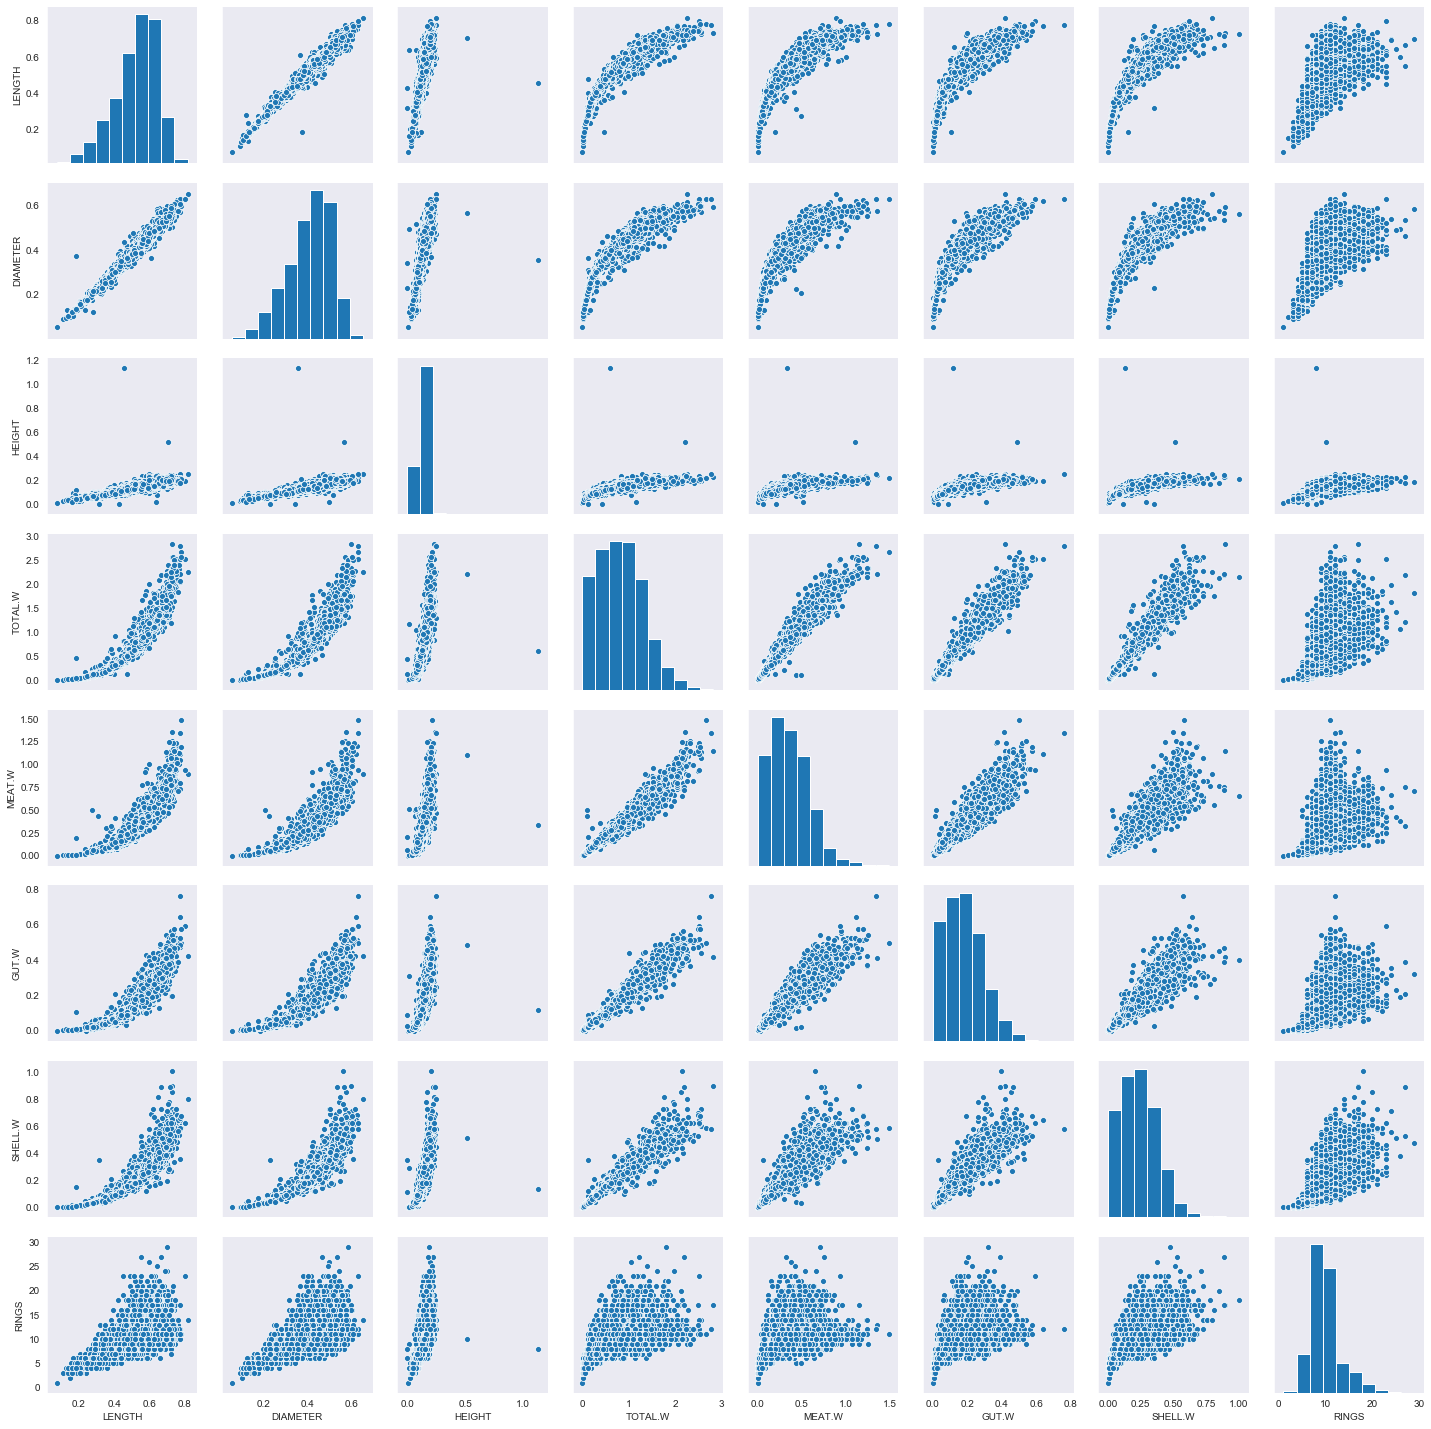

In [6]:
sb.pairplot(data = sexless)

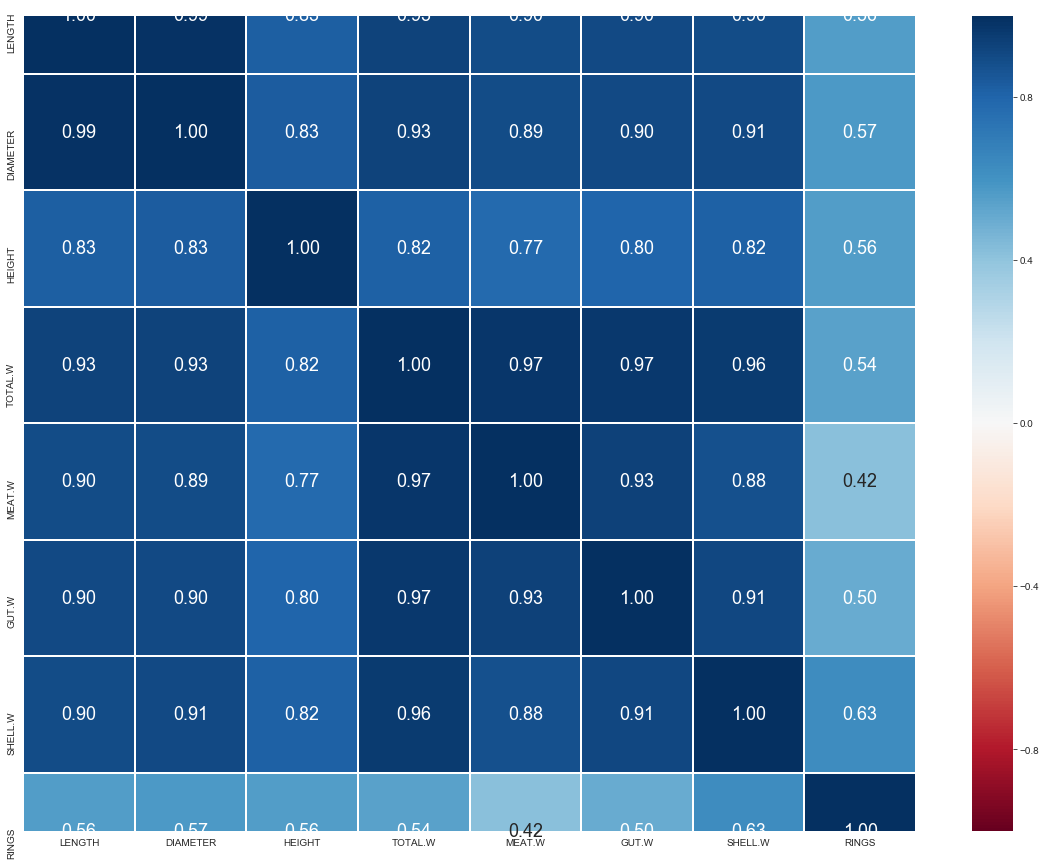

In [7]:
plt.subplots(figsize=(20, 15))
sb.heatmap(sexless.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu")

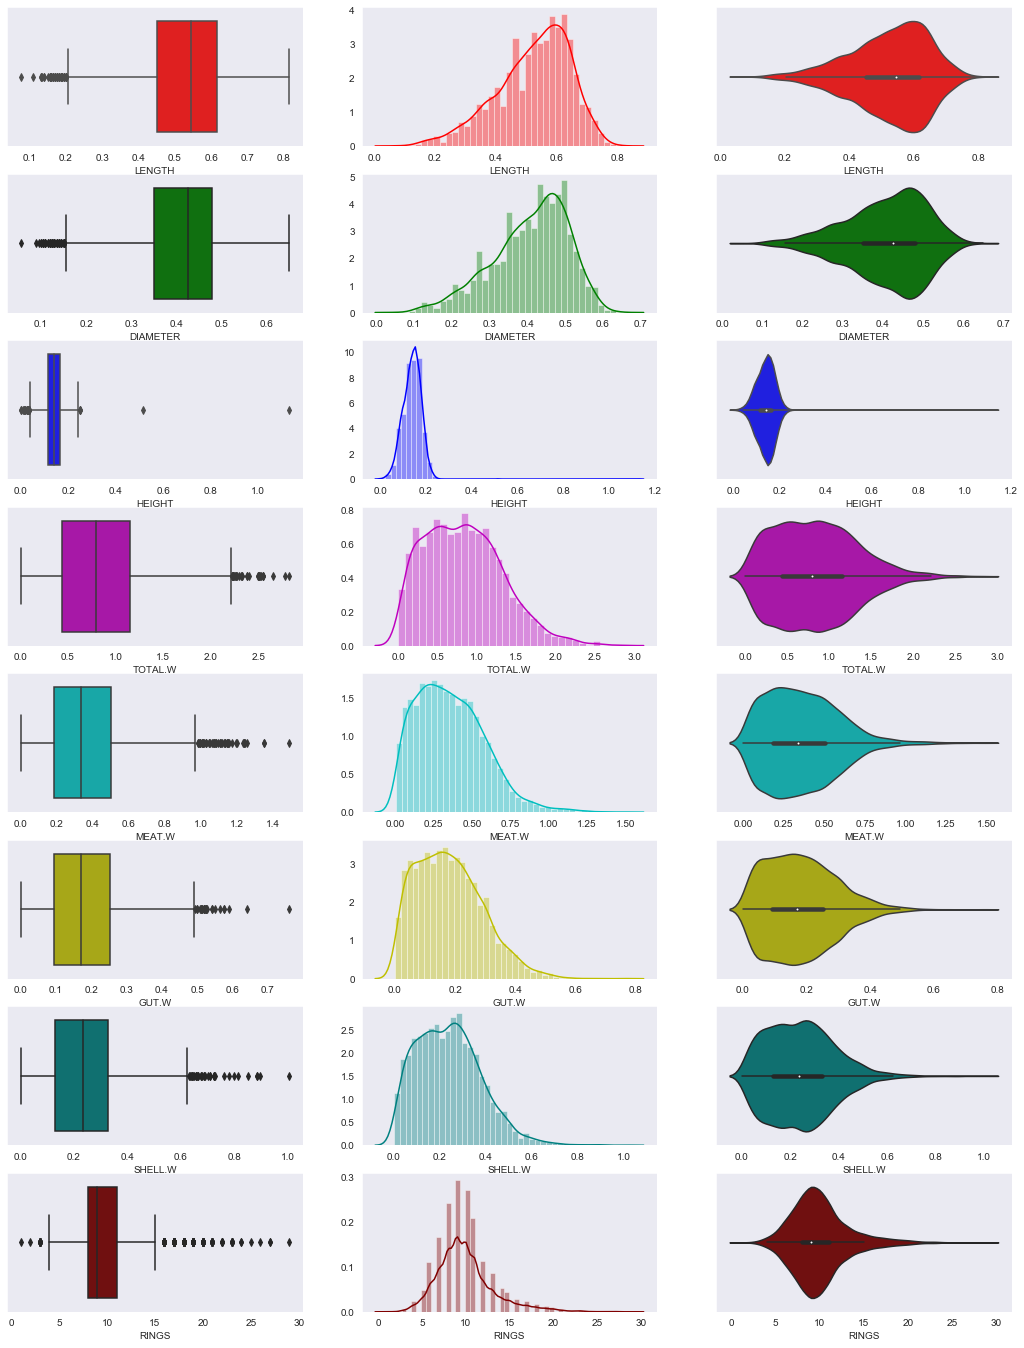

In [8]:
f, axes = plt.subplots(8, 3, figsize=(18, 24))
colors = ["r", "g", "b", "m", "c", "y", "#008080", "#800000"]

count = 0
for var in sexless:
    sb.boxplot(sexless[var], orient = "h", color = colors[count], ax = axes[count,0])
    sb.distplot(sexless[var], color = colors[count], ax = axes[count,1])
    sb.violinplot(sexless[var], color = colors[count], ax = axes[count,2])
    count += 1

### Predictors

Looking at the heatmap in particular, `MEAT.W` seems to be the only one with lower correlation. Take the rest as predictors.

In [28]:
predictors = sexless.drop(['MEAT.W', 'RINGS'], axis = 1)
predictors

,LENGTH,DIAMETER,HEIGHT,TOTAL.W,GUT.W,SHELL.W
0,0.455,0.365,0.095,0.5140,0.1010,0.1500
1,0.350,0.265,0.090,0.2255,0.0485,0.0700
2,0.530,0.420,0.135,0.6770,0.1415,0.2100
3,0.440,0.365,0.125,0.5160,0.1140,0.1550
4,0.330,0.255,0.080,0.2050,0.0395,0.0550
...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.2390,0.2490
4173,0.590,0.440,0.135,0.9660,0.2145,0.2605
4174,0.600,0.475,0.205,1.1760,0.2875,0.3080
4175,0.625,0.485,0.150,1.0945,0.2610,0.2960


In [10]:
predictee = pd.DataFrame(sexless['RINGS'])
predictee

,RINGS
0,15
1,7
2,9
3,10
4,7
...,...
4172,11
4173,10
4174,9
4175,10


In [11]:
predictee['RINGS'].value_counts()

9     689
10    634
8     568
11    487
7     391
12    267
6     259
13    203
14    126
5     115
15    103
16     67
17     58
4      57
18     42
19     32
20     26
3      15
21     14
23      9
22      6
24      2
27      2
1       1
25      1
2       1
26      1
29      1
Name: RINGS, dtype: int64

Convert the range of `RINGS` from `1-29` to 2 ranges: `0-14` and `15-29`

In [3]:
labels = labels = ["{0} - {1}".format(i, i + 14) for i in range(0, 30, 15)]
predictee['RINGS_GROUPED'] = pd.cut(predictee.RINGS, range(0, 45, 15), right=False, labels=labels)
predictee

NameError: name 'predictee' is not defined

### Optimizing parameters for sklearn DecisionTree

In [2]:
X_train, X_test, y_train, y_test = train_test_split(predictors, predictee['RINGS'],
                                                    test_size = 0.25)

NameError: name 'predictors' is not defined

Ranges of parameters to try

In [30]:
dimensions = [Integer(low=2, high=20, name='max_depth'),
              Real(low=1e-6, high=0.2, name='min_samples_split'),
              Real(low=1e-6, high=0.2, name='min_samples_leaf'),
              Integer(low=10, high=500, name='max_leaf_nodes'),
              Real(low=1e-6, high=0.2, name='min_impurity_decrease')]

In [31]:
default_parameters = [10, 1e-5, 1e-5, 400, 1e-5]

In [32]:
def create_model(max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes,
                 min_impurity_decrease):
    
    tree = DecisionTreeClassifier(max_depth = max_depth, min_samples_split = min_samples_split,
                                  min_samples_leaf = min_samples_leaf, max_leaf_nodes = max_leaf_nodes,
                                  min_impurity_decrease = min_impurity_decrease)
    return tree

In [33]:
@use_named_args(dimensions=dimensions)
def evaluate_model(max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes,
                   min_impurity_decrease):
    
    tree = create_model(max_depth, min_samples_split, min_samples_leaf,
                        max_leaf_nodes, min_impurity_decrease)
    
    tree.fit(X_train, y_train)
    
    accuracy = tree.score(X_test, y_test)
    change = 'No'
    
    global best_accuracy
    global iteration
    
    iteration += 1

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        change = 'Yes'
        
    print(f"Iteration: {iteration}")
    print("Best Accuracy: {0:.2}".format(best_accuracy) + f" Changed: {change}")
    change = 'No'
    print(f"max_depth: {max_depth}")
    print("min_samples_split: {0:.1e}".format(min_samples_split))
    print("min_samples_leaf: {0:.1e}".format(min_samples_leaf))
    print(f"max_leaf_nodes: {max_leaf_nodes}")
    print("min_impurity_decrease: {0:.1e}".format(min_impurity_decrease))
    print()
    
    return -accuracy

In [34]:
iteration = 0
best_accuracy = 0

search_result = gp_minimize(func=evaluate_model,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=150,
                            x0=default_parameters,
                            n_random_starts=20,
                            n_restarts_optimizer=10,
                            random_state=1)

Iteration: 1
Best Accuracy: 0.23 Changed: Yes
max_depth: 10
min_samples_split: 1.0e-05
min_samples_leaf: 1.0e-05
max_leaf_nodes: 400
min_impurity_decrease: 1.0e-05

Iteration: 2
Best Accuracy: 0.23 Changed: No
max_depth: 20
min_samples_split: 1.9e-01
min_samples_leaf: 2.6e-02
max_leaf_nodes: 500
min_impurity_decrease: 4.7e-02

Iteration: 3
Best Accuracy: 0.23 Changed: No
max_depth: 9
min_samples_split: 7.8e-02
min_samples_leaf: 1.3e-01
max_leaf_nodes: 468
min_impurity_decrease: 1.7e-01

Iteration: 4
Best Accuracy: 0.23 Changed: No
max_depth: 8
min_samples_split: 1.0e-01
min_samples_leaf: 8.9e-02
max_leaf_nodes: 122
min_impurity_decrease: 1.1e-01

Iteration: 5
Best Accuracy: 0.23 Changed: No
max_depth: 18
min_samples_split: 9.1e-02
min_samples_leaf: 8.6e-02
max_leaf_nodes: 470
min_impurity_decrease: 1.6e-01

Iteration: 6
Best Accuracy: 0.23 Changed: No
max_depth: 15
min_samples_split: 1.6e-01
min_samples_leaf: 1.9e-02
max_leaf_nodes: 264
min_impurity_decrease: 1.7e-01

Iteration: 7
Best

Iteration: 51
Best Accuracy: 0.28 Changed: No
max_depth: 9
min_samples_split: 2.0e-01
min_samples_leaf: 6.9e-02
max_leaf_nodes: 192
min_impurity_decrease: 6.1e-04

Iteration: 52
Best Accuracy: 0.28 Changed: No
max_depth: 4
min_samples_split: 1.8e-01
min_samples_leaf: 1.9e-02
max_leaf_nodes: 211
min_impurity_decrease: 5.0e-05

Iteration: 53
Best Accuracy: 0.28 Changed: No
max_depth: 5
min_samples_split: 1.8e-01
min_samples_leaf: 1.1e-02
max_leaf_nodes: 307
min_impurity_decrease: 2.0e-04

Iteration: 54
Best Accuracy: 0.28 Changed: No
max_depth: 5
min_samples_split: 2.0e-01
min_samples_leaf: 3.4e-03
max_leaf_nodes: 109
min_impurity_decrease: 3.2e-04

Iteration: 55
Best Accuracy: 0.28 Changed: No
max_depth: 14
min_samples_split: 1.2e-03
min_samples_leaf: 3.5e-03
max_leaf_nodes: 80
min_impurity_decrease: 1.5e-01

Iteration: 56
Best Accuracy: 0.28 Changed: No
max_depth: 12
min_samples_split: 1.9e-01
min_samples_leaf: 7.7e-02
max_leaf_nodes: 460
min_impurity_decrease: 4.5e-04

Iteration: 57
B

Iteration: 101
Best Accuracy: 0.28 Changed: No
max_depth: 15
min_samples_split: 4.9e-03
min_samples_leaf: 1.2e-01
max_leaf_nodes: 209
min_impurity_decrease: 1.0e-03

Iteration: 102
Best Accuracy: 0.28 Changed: No
max_depth: 13
min_samples_split: 3.5e-03
min_samples_leaf: 1.2e-01
max_leaf_nodes: 224
min_impurity_decrease: 2.3e-04

Iteration: 103
Best Accuracy: 0.28 Changed: No
max_depth: 5
min_samples_split: 8.3e-04
min_samples_leaf: 4.5e-02
max_leaf_nodes: 233
min_impurity_decrease: 2.4e-04

Iteration: 104
Best Accuracy: 0.28 Changed: No
max_depth: 8
min_samples_split: 3.7e-03
min_samples_leaf: 1.0e-01
max_leaf_nodes: 481
min_impurity_decrease: 4.0e-04

Iteration: 105
Best Accuracy: 0.28 Changed: No
max_depth: 15
min_samples_split: 1.9e-01
min_samples_leaf: 1.2e-01
max_leaf_nodes: 301
min_impurity_decrease: 3.9e-04

Iteration: 106
Best Accuracy: 0.28 Changed: No
max_depth: 16
min_samples_split: 2.0e-01
min_samples_leaf: 1.3e-02
max_leaf_nodes: 476
min_impurity_decrease: 2.0e-04

Iterat

In [35]:
optimized = search_result.x
optimized

[9, 0.18643325998840649, 0.10359397798772374, 282, 0.00026863792827151284]

In [36]:
tree = DecisionTreeClassifier(max_depth = optimized[0], min_samples_split = optimized[1],
                              min_samples_leaf = optimized[2], max_leaf_nodes = optimized[3],
                              min_impurity_decrease = optimized[4])
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
                       max_features=None, max_leaf_nodes=282,
                       min_impurity_decrease=0.00026863792827151284,
                       min_impurity_split=None,
                       min_samples_leaf=0.10359397798772374,
                       min_samples_split=0.18643325998840649,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [37]:
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", tree.score(X_train, y_train))
print()

print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", tree.score(X_test, y_test))
print()

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.2656449553001277

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.2822966507177033



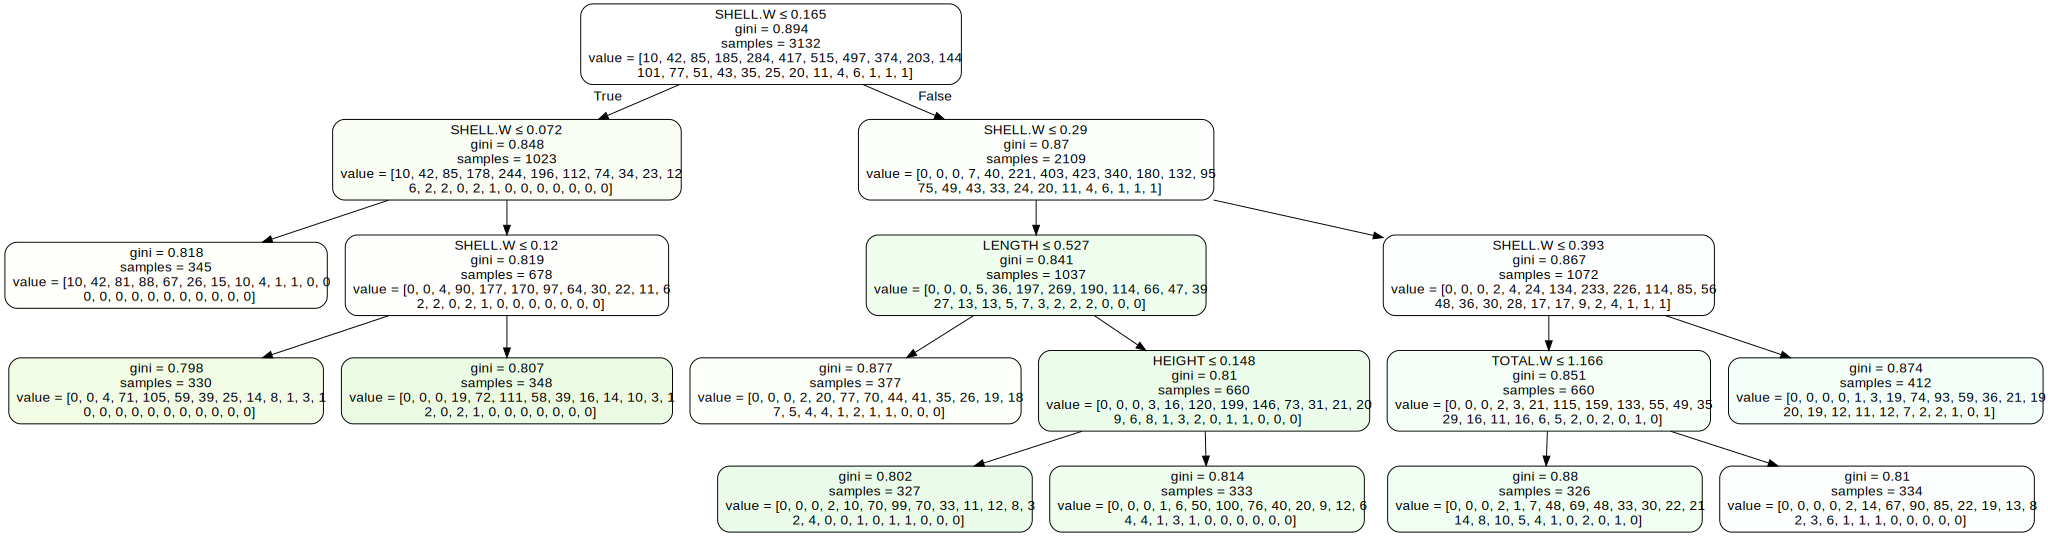

In [38]:
treedot = export_graphviz(tree, feature_names = X_train.columns, out_file = None,
                          filled = True, rounded = True, special_characters = True)
graphviz.Source(treedot)

gini == 0 means node purely this one class for eg: `15-29`